# Learning XOR with an Optical network with Kerr-nonlinearities

### Stats for training with SB for different betas (Quadrature Basis)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import time

# Parameters
np.random.seed(228) # seed
N = 10  # Number of nodes
N_out = 1  # Number of output nodes
kappa = np.ones(N)  # Decay rates
g = 0.2  # Nonlinearity
initial_J = 2/N * np.random.randn(N, N)  # Connectivity matrix
initial_J = (initial_J + initial_J.T) / 2
beta = 1e-2  # Perturbation magnitude

# Kerr nonlinearity type ("self", "self" + "cross all-to-all", "self" + "cross between neighbors"):
# 1) only self-Kerr-nonlinearity
G = np.eye(N) 
# 2) cross-Kerr-nonlinearities between (j-1) <-> j <-> (j+1)

# Initialize state
initial_y0 = np.random.randn(2 * N) 

# XOR Dataset
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = np.array([0, 1, 1, 0])

# System dynamics
def system(t, y, args):
    kappa, g, J, x_in, p_in = args
    N = len(kappa)
    x = y[:N]
    p = y[N:]
    dxdt = -0.5 * kappa * x + np.matmul(J,p) + 0.5 * g * p * np.matmul(G, (x**2 + p**2)) - np.sqrt(kappa) * x_in
    dpdt = -0.5 * kappa * p - np.matmul(J,x) - 0.5 * g * x * np.matmul(G, (x**2 + p**2)) - np.sqrt(kappa) * p_in
    return np.concatenate([dxdt, dpdt])

x_in = np.zeros(N)
p_in = np.zeros(N)


def equilibrium(x, J, x_in, p_in):
    bar_x = x[:N]
    bar_p = x[N:]
    eq_real = -0.5 * kappa * bar_x + np.matmul(J,bar_p) + 0.5 * g * bar_p * np.matmul(G, (bar_x**2 + bar_p**2)) - np.sqrt(kappa) * x_in
    eq_imag = -0.5 * kappa * bar_p - np.matmul(J,bar_x) - 0.5 * g * bar_x * np.matmul(G, (bar_x**2 + bar_p**2)) - np.sqrt(kappa) * p_in
    
    return np.concatenate((eq_real, eq_imag))

sigma_z = np.block([
    [np.eye(N), np.zeros((N,N))],
    [np.zeros((N,N)), -np.eye(N)]
])

In [ ]:
# Runge Kutta ode solver
def rk4_step(f, y, t, dt, args):
    """Performs a single step of the 4th-order Runge-Kutta method for solving ODEs."""
    k1 = f(t, y, args)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1 * dt, args)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2 * dt, args)
    k4 = f(t + dt, y + k3 * dt, args)
    
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_rk4(f, y0, t_span, dt, args):
    """Solves an ODE using RK4 over a time range."""
    t_values = np.arange(t_span[0], t_span[1] + dt, dt)
    y_values = []
    y_values.append(y0)
    
    for i in range(1, len(t_values)):
        y_values.append(rk4_step(f, y_values[i-1], t_values[i-1], dt, args))
    
    return t_values, np.array(y_values)

tmax = 40
dt = 0.1

In [ ]:
# Generate a list of random seeds
num_configs = 10  # Number of random configurations per N

random_seeds = [np.random.randint(0, 100000) for _ in range(num_configs)]

histories = []

beta_values = np.arange(0.001, 0.252, 0.001)

for beta in beta_values:
    J = initial_J.copy()
    learning_rate = 1e-3 
    
    # Initialize state
    loss_history = []
    
    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        epoch_loss = 0
        for input_vec, target in zip(inputs, targets):
            y0 = initial_y0.copy()
            # Set inputs
            x_in = 1e-8 * np.ones(N)
            p_in = 1e-8 * np.ones(N)
            x_in[:2] = input_vec 

            # Inference Phase:
            # Compute steady state using fsolve (faster without JAX):
            solution_free = fsolve(equilibrium, y0, args=(J, x_in, p_in))

            # Compute steady state using RK4:
            #solution_free = solve_ivp(system, [0, tmax], y0, args=(kappa, g, J, x_in, p_in), dense_output=True, max_step=0.1).y[:,-1]
            #_ , steady_state = solve_rk4(system, y0, (0,tmax), dt, args=(kappa, g, J, x_in, p_in))
            #solution_free = steady_state[-1]

            x_free = solution_free[:N]
            p_free = solution_free[N:]

            y0 = solution_free # update initial condition 

            # Compute loss for the current sample
            y = 10*x_free[4]
            loss = (y - target)**2    
            epoch_loss += loss

            # Feedback Phase:
            # Error signal
            # using U = sigma_z (equivalent to sigma_x in the a(t)-basis)
            x_in[4] += beta * 2 * 10 * (y - target)

            # Compute steady state using fsolve (faster without JAX):
            solution_perturbed = fsolve(equilibrium, y0, args=(J, x_in, p_in))

            # Compute steady state using RK4:
            #solution_perturbed = solve_ivp(system, [0, tmax], y0, args=(kappa, g, J, x_in, p_in), dense_output=True, max_step=0.1).y[:,-1]
            #_ , steady_state = solve_rk4(system, y0, (0,tmax), dt, args=(kappa, g, J, x_in, p_in))
            #solution_perturbed = steady_state[-1]

            y0 = solution_perturbed # update initial condition 

            # Update weights 
            # using U = sigma_z (equivalent to sigma_x in the a(t)-basis)
            for j in range(N):
                for l in range(N):
                        dFdJ_jl = np.zeros(2 * N)
                        dFdJ_jl[j] = p_free[l]
                        dFdJ_jl[l] = p_free[j]
                        dFdJ_jl[j+N] = - x_free[l] 
                        dFdJ_jl[l+N] = - x_free[j] 
                        if j == l:
                            dFdJ_jl[j] /= 2
                            dFdJ_jl[j+N] /= 2
                        dJ_jl = (0.5 * learning_rate) * dFdJ_jl.T @ sigma_z @ (solution_perturbed - solution_free)/beta 
                        J[j,l] += dJ_jl
                        J[l,j] += dJ_jl 


        # Average loss for the epoch
        epoch_loss = epoch_loss / len(inputs)
        loss_history.append(epoch_loss)

    histories.append(loss_history.copy())

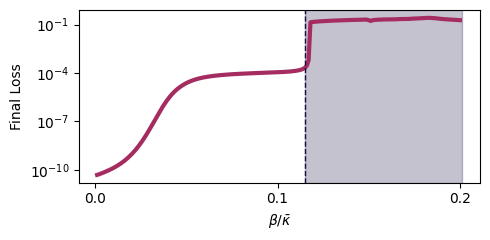

In [18]:
# Get the last element of each sublist in histories
last_losses = [histories[j][-1] for j in range(len(histories)) ]

# Example input (replace with your actual values)
colors = plt.cm.inferno(np.linspace(0, 1, 10))

# Threshold position for the vertical line
x_vline = .115  # change as needed

# Plot
plt.figure(figsize=(5, 2.5))  
plt.xlabel(r'$\beta/\bar{\kappa}$')
plt.yscale('log')
plt.yticks([1e-1, 1e-4, 1e-7, 1e-10])
plt.xticks([0, 0.1, 0.2])
plt.ylabel('Final Loss')

# Plot the loss curve
plt.plot(beta_values[0:200], last_losses[0:200], color=colors[4], linewidth=3)

# Add vertical line
plt.axvline(x=x_vline, color=colors[1], linestyle='--', linewidth=1)

# Add shaded region to the right of the vertical line
plt.axvspan(x_vline, beta_values[200], color=colors[1], alpha=0.25)
plt.tight_layout()
plt.show()